# CITE-seq data integration with weighted nearest neighbours

This noteboks demonstrated multimodal data integration using *weighted nearest neighbours*.

Multimodal nearest neighbor search for two modalities was described in the Seurat 4 paper ([Hao et al, 2020](https://doi.org/10.1101/2020.10.12.335331)) and was extended to arbitrary modality numbers in the TEA-seq paper ([Swanson et al, 2020](https://doi.org/10.1101/2020.09.04.283887)).

The data used in this notebook is on peripheral blood mononuclear cells (PBMCs) and [has been provided by 10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.2/5k_pbmc_protein_v3).

In [1]:
# Change directory to the root folder of the repository
import os
os.chdir("../")

## Load libraries and data

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

from matplotlib import colors
%matplotlib inline

In [3]:
import muon as mu

In [4]:
mdata = mu.read("data/pbmc5k_citeseq.h5mu")

In [5]:
with mu.set_options(display_style="html", display_html_expand=0b000):
    display(mdata)

MuData object with n_obs × n_vars = 3891 × 17838
  obs:	'louvain', 'leiden'
  var:	'feature_types', 'gene_ids', 'highly_variable'
  obsm:	'X_mofa', 'X_umap'
  varm:	'LFs'
  obsp:	'connectivities', 'distances'
  2 modalities
    prot:	3891 x 32
      var:	'gene_ids', 'feature_types', 'highly_variable'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	3891 x 17806
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

## MOFA integration

[In the previous chapter](./1-CITE-seq-PBMC-5k.ipynb), the data has been preprocessed and integrated with MOFA:

/usr/local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


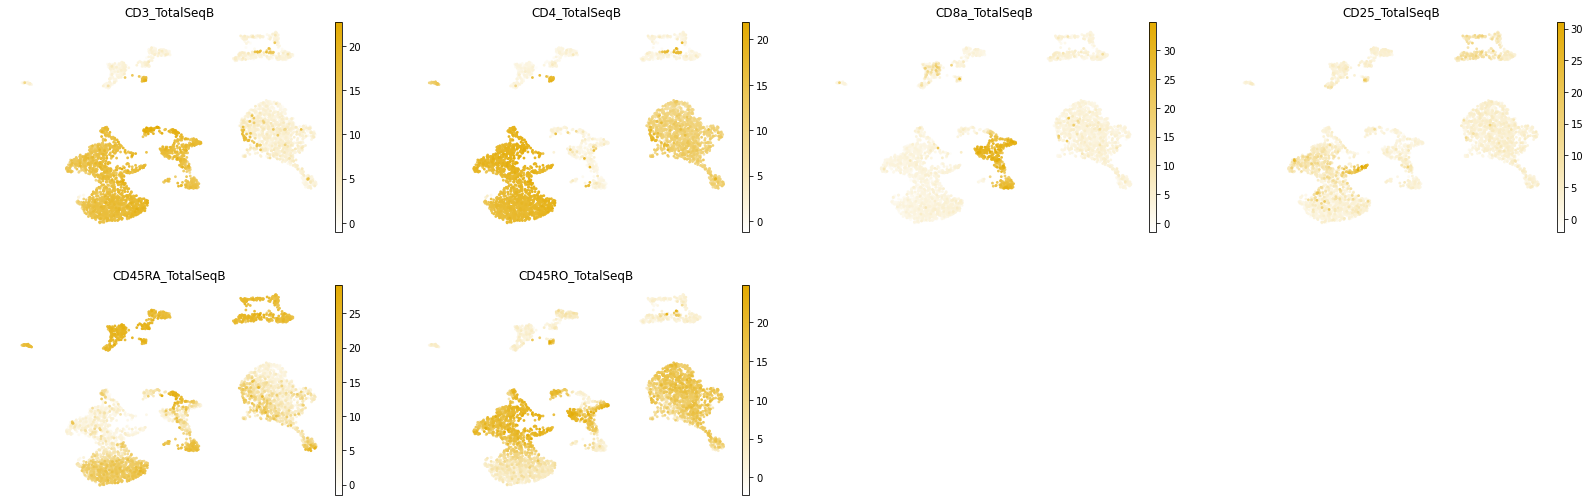

In [6]:
# Make a colour scale
prot_cmap = colors.LinearSegmentedColormap.from_list('protein cmap', ['#FFFFFF','#E3AA00'], N=256)

mu.pl.umap(mdata, color=['CD3_TotalSeqB',                       # T cells
                         'CD4_TotalSeqB', 'CD8a_TotalSeqB',     # CD4+/CD8+ T cells
                         'CD25_TotalSeqB',                      # regulatory T cells 
                         'CD45RA_TotalSeqB', 'CD45RO_TotalSeqB' # naïve/memory
                         ], 
           frameon=False,
           cmap=prot_cmap,
          )

We will save the MOFA-based UMAP space under a distinctive name:

In [7]:
mdata.obsm["X_mofa_umap"] = mdata.obsm["X_umap"]

## WNN integration

In the MOFA integration above, cell neigbourhood graph was computed using MOFA factors that had been learned on both modalities.

We can also compute this graph using a weighted nearest neighbours (WNN) method. It will use nearest neighbour graphs for each modality and will generate a joint one. In `muon`, this is implemented under `mu.pp.neighbors` as a natural extension of `sc.pp.neighbors` from `scanpy`:

In [8]:
# Since subsetting was performed after calculating nearest neighbours,
# we have to calculate them again for each modality.
sc.pp.neighbors(mdata['rna'])
sc.pp.neighbors(mdata['prot'])

# Calculate weighted nearest neighbors
mu.pp.neighbors(mdata, key_added='wnn')

By default, modality weights are added to the `mdata.obs` data frame under the `rna:mod_weight` and `prot:mod_weight`, and this behaviour can be adjusted with options like `add_weights_to_modalities` to add weights to individual modalities instead and `weight_key` to change the name of the key.

The computed cell neighbourhood graph can be further used to compute UMAP coordinates.

The `use_rep` parameter is not a single values anymore for WNN, that's why `muon` provides `mu.tl.umap` to handle this case.

In [9]:
mdata.uns['wnn']['params']['use_rep']

{'prot': -1, 'rna': -1}

In [10]:
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)

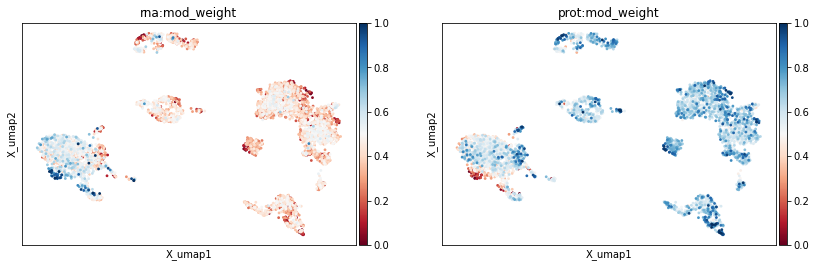

In [11]:
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='RdBu')

The computed cell neighbourhood graph can also be used for clustering:

In [12]:
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')

... storing 'rna:mt' as categorical
... storing 'feature_types' as categorical


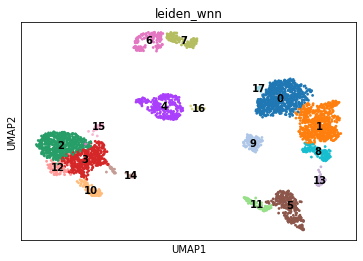

In [13]:
sc.pl.umap(mdata, color='leiden_wnn', legend_loc='on data')

Modality weights can be visualized per celltype with existing plotting functions:

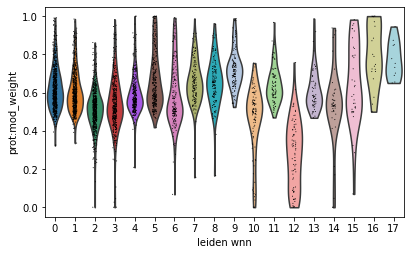

In [14]:
sc.pl.violin(mdata, groupby='leiden_wnn', keys='prot:mod_weight')

We will use a destcriptive name to save the WNN-based UMAP under:

In [15]:
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]

These embedding keys can be then easily used for plotting:

/usr/local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


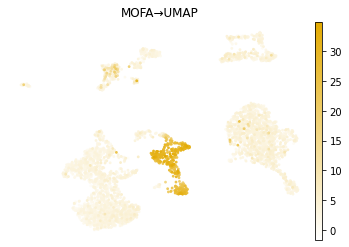

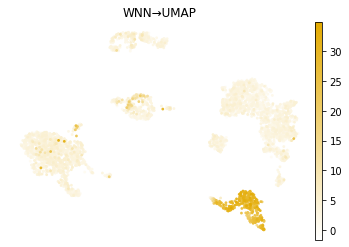

In [16]:
mu.pl.embedding(mdata, basis="X_mofa_umap", frameon=False, title="MOFA\u2192UMAP", color="CD8a_TotalSeqB", cmap=prot_cmap)
mu.pl.embedding(mdata, basis="X_wnn_umap", frameon=False, title="WNN\u2192UMAP", color="CD8a_TotalSeqB", cmap=prot_cmap)

In [17]:
# Save the integrated dataset
mdata.write("data/pbmc5k_citeseq_multiembed.h5mu")